In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score

In [2]:
df = pd.read_csv('../data_clean/AA_Supervised_dataset_50_50.csv')
df.head()

,contactID,campagneID,afspraak_Arbeidsmarkt,afspraak_Bedrijfsbeheer,afspraak_Duurzaamheid,afspraak_Familiebedrijfsmanagement,afspraak_Financieel,afspraak_Groeien en Netwerking,afspraak_Internationaal Ondernemen,afspraak_Lidmaatschap,...,5,0_campagne_type,1_campagne_type,2_campagne_type,3_campagne_type,4_campagne_type,5_campagne_type,Online,Offline,ingeschreven
0,11FDBA20-6ACE-E511-9397-005056B06EB4,C064E2B4-BA22-E811-80F0-001DD8B72B61,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1
1,1EE899E9-E4D1-EC11-A7B5-000D3A480276,66AB8B6E-E681-ED11-81AD-6045BD895CDC,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1
2,1EE899E9-E4D1-EC11-A7B5-000D3A480276,66AB8B6E-E681-ED11-81AD-6045BD895CDC,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1
3,1EE899E9-E4D1-EC11-A7B5-000D3A480276,66AB8B6E-E681-ED11-81AD-6045BD895CDC,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1
4,1EE899E9-E4D1-EC11-A7B5-000D3A480276,92C9E001-1DB4-EC11-983F-00224883CCEA,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82318 entries, 0 to 82317
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   contactID                           82318 non-null  object
 1   campagneID                          82318 non-null  object
 2   afspraak_Arbeidsmarkt               82318 non-null  int64 
 3   afspraak_Bedrijfsbeheer             82318 non-null  int64 
 4   afspraak_Duurzaamheid               82318 non-null  int64 
 5   afspraak_Familiebedrijfsmanagement  82318 non-null  int64 
 6   afspraak_Financieel                 82318 non-null  int64 
 7   afspraak_Groeien en Netwerking      82318 non-null  int64 
 8   afspraak_Internationaal Ondernemen  82318 non-null  int64 
 9   afspraak_Lidmaatschap               82318 non-null  int64 
 10  afspraak_Logistiek en Transport     82318 non-null  int64 
 11  afspraak_Plato & Bryo               82318 non-null  in

In [4]:
df['ingeschreven'].value_counts()

ingeschreven
1    41159
0    41159
Name: count, dtype: int64

In [5]:
# opsplitting in X en y
X = df.drop(['ingeschreven', 'campagneID', 'contactID'], axis=1)
y = df['ingeschreven']

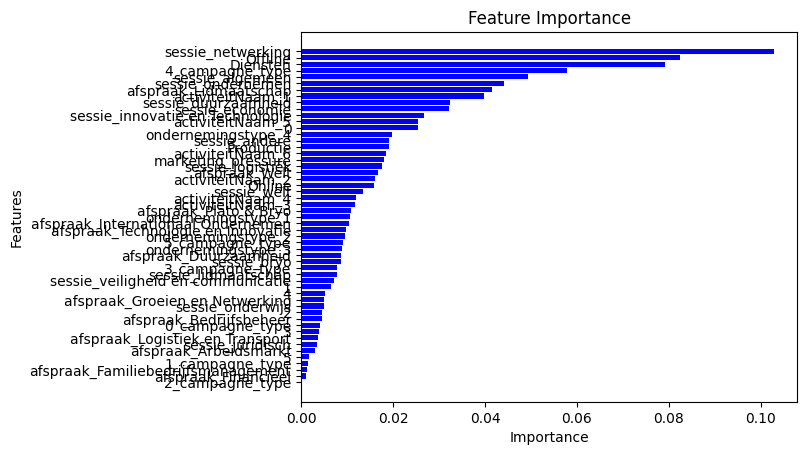

<Figure size 1500x1500 with 0 Axes>

In [6]:
# Checking feature importance
forest_clf = RandomForestClassifier(random_state=42, n_estimators=500, n_jobs=-1)
forest_clf.fit(X, y)

importances = forest_clf.feature_importances_
featureNames = X.columns

features = pd.DataFrame({'feature': featureNames, 'importance': importances})
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

plt.barh(features.index, features['importance'], color='b')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.figure(figsize=(15, 15))
plt.show()

In [6]:
# opsplitting in train en test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['ingeschreven'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((65854, 53), (16464, 53), (65854,), (16464,))

In [7]:
def models_gs(model):
    try:
        grid_search = GridSearchCV(model["model"], param_grid=model["param_grid"], cv=5, scoring="accuracy", return_train_score=True, n_jobs=-1)
        grid_search.fit(X_train, y_train)
    
        best_model = grid_search.best_estimator_
        return (best_model, grid_search.best_score_)
    
    except Exception as e:
        print(f"{model['name']} failed with error: {e}")

In [9]:
non_ensemble_models_param_grid = [
   {
      "name":"linearsvc",
      "model": LinearSVC(random_state=42),
      "param_grid": {
         "C":[0.1, 0.5, 1, 2.5, 5, 10, 20, 50, 75, 100, 125, 150, 200, 250, 500, 1000],
         "penalty": ["l2"],
         "loss": ["loss", "log_loss", "hinge", "squared_hinge"],
      }
   },
   {
      "name":"sgdclassifier",
      "model": SGDClassifier(random_state=42),
      "param_grid":{
         "alpha":[0.001, 0.01, 0.1, 0.5, 1],
         "penalty":["l2"],
         "max_iter": [1000],
         "loss": ["log_loss"]
      }
   },
   {
      "name":"logisticregression",
      "model": LogisticRegression(random_state=42, max_iter=1000),
      "param_grid":{
         "C":[0.1, 0.5, 1, 2.5, 5, 10, 20, 50, 75, 100, 125, 150, 200, 250, 500, 1000],
         "penalty":["l2"]
      }
   },
   {
      "name":"decisiontreeclassifier",
      "model": DecisionTreeClassifier(random_state=42),
      "param_grid":{
         "max_depth":[5, 10, 15, 20, 25, 30, 35],
         "min_samples_split":[2, 5, 10, 15, 20, 25],
         "min_samples_leaf":[2, 5, 10, 15, 20, 25],
         "criterion":["gini", "entropy", "log_loss"]
      }
   },
]

In [10]:
for model in non_ensemble_models_param_grid:
  print(f'Starting {model["name"]}...')
  gs = models_gs(model)
  print(gs)

Starting linearsvc...
(LinearSVC(C=0.1, random_state=42), 0.833146021299639)
Starting sgdclassifier...
(SGDClassifier(alpha=0.001, loss='log_loss', random_state=42), 0.8220153723378623)
Starting logisticregression...
(LogisticRegression(C=100, max_iter=1000, random_state=42), 0.836410842261985)
Starting decisiontreeclassifier...
(DecisionTreeClassifier(max_depth=30, min_samples_leaf=5, min_samples_split=25,
                       random_state=42), 0.8556655255239883)


In [8]:
best_models = [
  {
    'name': 'linearsvc',
    'model': LinearSVC(C=0.1, random_state=42)
  },
  {
    'name': 'sgdclassifier',
    'model': SGDClassifier(alpha=0.001, loss='log_loss', random_state=42)
  },
  {
    'name': 'logisticregression',
    'model': LogisticRegression(C=100, max_iter=1000, random_state=42)
  },
  {
    'name': 'deciciontreeclassifier',
    'model': DecisionTreeClassifier(max_depth=30, min_samples_leaf=5, min_samples_split=25, random_state=42)
  },
]

In [9]:
rfc = {
      "name":"randomforestclassifier",
      "model": RandomForestClassifier(random_state=42, n_jobs=-1),
      "param_grid":{
         "n_estimators":[50, 75, 100, 125, 150, 175, 200],
         "min_samples_split":[2, 5, 10, 15],
         "min_samples_leaf":[2, 5, 10, 15],
         "criterion": ["gini", "entropy", "log_loss"],
      }
    }

In [10]:
print(f"Starting {rfc['name']}...")
gs = models_gs(rfc)
print(gs)

Starting randomforestclassifier...
(RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       n_estimators=200, n_jobs=-1, random_state=42), 0.8603729195667963)


In [11]:
best_models.append({
  'name': 'randomforestclassifier',
  'model': RandomForestClassifier(criterion='entropy', min_samples_leaf=2, n_estimators=200, n_jobs=-1, random_state=42)
})

In [14]:
voting_clfs = [
    {
        "name": "votingclassifier",
        "diff": "hard",
        "model": VotingClassifier(estimators=[
            ('linsvc', best_models[0]['model']),
            ('sgd', best_models[1]['model']),
            ('lr', best_models[2]['model']),
            ('dt', best_models[3]['model']),
            ('rf', best_models[4]['model']),
        ], voting='hard', n_jobs=-1),
        "param_grid": {
            'weights': [
                [1, 1, 1, 1, 1],
                [1, 1, 1, 1, 2], 
                [1, 1, 1, 2, 2], 
                [1, 1, 2, 2, 2], 
                [1, 2, 2, 2, 2],
                [2, 2, 2, 2, 2]
            ]
        }
    },
    {
        "name": "votingclassifier",
        "diff": "soft",
        "model": VotingClassifier(estimators=[
            ('sgd', best_models[1]['model']),
            ('lr', best_models[2]['model']),
            ('dt', best_models[3]['model']),
            ('rf', best_models[4]['model']),
        ], voting='soft', n_jobs=-1),
        "param_grid": {
            'weights': [
                [1, 1, 1, 1], 
                [1, 1, 1, 2], 
                [1, 1, 2, 2], 
                [1, 2, 2, 2], 
                [2, 2, 2, 2]
            ]
        }
    }
]

In [15]:
for model in voting_clfs:
    print(f"Starting {model['diff']}-voting model...")
    gs = models_gs({
        "name": model["name"],
        "model": model["model"],
        "param_grid": model["param_grid"]
    })
    print(gs)

Starting hard-voting model...
(VotingClassifier(estimators=[('linsvc', LinearSVC(C=0.1, random_state=42)),
                             ('sgd',
                              SGDClassifier(alpha=0.001, loss='log_loss',
                                            random_state=42)),
                             ('lr',
                              LogisticRegression(C=100, max_iter=1000,
                                                 random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=30,
                                                     min_samples_leaf=5,
                                                     min_samples_split=25,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     min_samples_leaf=2,
                                      

In [16]:
best_models.append({
  "name": "votingclassifier_hard",
  "model": VotingClassifier(estimators=[('linsvc', LinearSVC(C=0.1, random_state=42)),
                             ('sgd',
                              SGDClassifier(alpha=0.001, loss='log_loss',
                                            random_state=42)),
                             ('lr',
                              LogisticRegression(C=100, max_iter=1000,
                                                 random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=30,
                                                     min_samples_leaf=5,
                                                     min_samples_split=25,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     min_samples_leaf=2,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42))],
                 n_jobs=-1, weights=[1, 1, 1, 2, 2])
})

best_models.append({
  "name": "votingclassifier_soft",
  "model": VotingClassifier(estimators=[('sgd',
                              SGDClassifier(alpha=0.001, loss='log_loss',
                                            random_state=42)),
                             ('lr',
                              LogisticRegression(C=100, max_iter=1000,
                                                 random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=30,
                                                     min_samples_leaf=5,
                                                     min_samples_split=25,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     min_samples_leaf=2,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42))],
                 n_jobs=-1, voting='soft', weights=[1, 1, 2, 2])
})

In [17]:
bagging_clf = {
    "name": 'BaggingClassifier',
    "model": BaggingClassifier(random_state=42, n_jobs=-1, oob_score=True),
    "param_grid": {
        "base_estimator": [best_models[3]["model"]],
        "n_estimators": [10, 50, 100, 150],
        "bootstrap": [True, False],
        "max_samples": [0.5, 1.0, 2.0, 5.0]
    }
}

In [18]:
print(f"Starting {bagging_clf['name']}...")
gs = models_gs(bagging_clf)
print(gs)

Starting BaggingClassifier...
(BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=30,
                                                        min_samples_leaf=5,
                                                        min_samples_split=25,
                                                        random_state=42),
                  n_estimators=50, n_jobs=-1, oob_score=True, random_state=42), 0.8587784776233789)


In [19]:
best_models.append({
  "name": "BaggingClassifier",
  "model": BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=30,
                                                        min_samples_leaf=5,
                                                        min_samples_split=25,
                                                        random_state=42),
                  n_estimators=50, n_jobs=-1, oob_score=True, random_state=42)
})

In [20]:
adaboost_clf = {
    "name": 'AdaBoostClassifier',
    "model": AdaBoostClassifier(random_state=42),
    "param_grid": {
        "base_estimator": [best_models[3]["model"]],
        "n_estimators": [10, 50, 100, 150],
        "learning_rate": [0.1, 0.5, 1.0, 2.0],
        "algorithm": ['SAMME.R']
    }
}

In [21]:
print(f"Starting {adaboost_clf['name']}...")
gs = models_gs(adaboost_clf)
print(gs)

Starting AdaBoostClassifier...
(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=30,
                                                         min_samples_leaf=5,
                                                         min_samples_split=25,
                                                         random_state=42),
                   learning_rate=0.5, n_estimators=100, random_state=42), 0.8567740636324702)


In [22]:
best_models.append({
  "name": "AdaBoostClassifier",
  "model": AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=30,
                                                         min_samples_leaf=5,
                                                         min_samples_split=25,
                                                         random_state=42),
                   learning_rate=0.5, n_estimators=100, random_state=42)
})

In [23]:
gradient_boosting_clf = {
    "name": 'GradientBoostingClassifier',
    "model": GradientBoostingClassifier(random_state=42),
    "param_grid": {
        "n_estimators": [10, 50, 100, 150],
        "learning_rate": [0.1, 0.5, 1.0, 2.0],
        "min_samples_split": [2, 5, 10],
    }
}

In [24]:
print(f"Starting {gradient_boosting_clf['name']}...")
gs = models_gs(gradient_boosting_clf)
print(gs)

Starting GradientBoostingClassifier...
(GradientBoostingClassifier(learning_rate=1.0, n_estimators=150, random_state=42), 0.8550885377996469)


In [25]:
best_models.append({
  "name": "GradientBoostingClassifier",
  "model": GradientBoostingClassifier(learning_rate=1.0, n_estimators=150, random_state=42)
})

In [26]:
estimators = [
    ('sgd', best_models[1]['model']),
    ('lr', best_models[2]['model']),
    ('dt', best_models[3]['model']),
    ('rf', best_models[4]['model']),
]

final_estimators = [
    ('sgd', SGDClassifier(random_state=42, loss='log_loss')),
    ('lr', LogisticRegression(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
]

stacking_clfs = [
    {
        "name": 'StackingClassifier',
        "diff": final_estimators[0][0],
        "model": StackingClassifier(estimators=estimators, final_estimator=final_estimators[0][1], n_jobs=-1),
        "param_grid": {}
    },
    {
        "name": 'StackingClassifier',
        "diff": final_estimators[1][0],
        "model": StackingClassifier(estimators=estimators, final_estimator=final_estimators[1][1], n_jobs=-1),
        "param_grid": {}
    },
    {
        "name": 'StackingClassifier',
        "diff": final_estimators[2][0],
        "model": StackingClassifier(estimators=estimators, final_estimator=final_estimators[2][1], n_jobs=-1),
        "param_grid": {}
    },
    {
        "name": 'StackingClassifier',
        "diff": final_estimators[3][0],
        "model": StackingClassifier(estimators=estimators, final_estimator=final_estimators[3][1], n_jobs=-1),
        "param_grid": {}
    }
]

In [27]:
for i in stacking_clfs:
    print(f"Starting {i['name']}_{i['diff']}...")
    gs = models_gs(i)
    print(gs)

Starting StackingClassifier_sgd...
(StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=100, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=30,
                                                       min_samples_leaf=5,
                                                       min_samples_split=25,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       min_samples_leaf=2,
                                                       n_estimators=200,
        

In [28]:
best_models.append({
  "name": "StackingClassifier_sgd",
  "model": StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=100, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=30,
                                                       min_samples_leaf=5,
                                                       min_samples_split=25,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       min_samples_leaf=2,
                                                       n_estimators=200,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=SGDClassifier(loss='log_loss',
                                                 random_state=42),
                   n_jobs=-1)
})
best_models.append({
  "name": "StackingClassifier_lr",
  "model": StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=100, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=30,
                                                       min_samples_leaf=5,
                                                       min_samples_split=25,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       min_samples_leaf=2,
                                                       n_estimators=200,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(random_state=42),
                   n_jobs=-1)
})
best_models.append({
  "name": "StackingClassifier",
  "model": StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=100, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=30,
                                                       min_samples_leaf=5,
                                                       min_samples_split=25,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       min_samples_leaf=2,
                                                       n_estimators=200,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=DecisionTreeClassifier(random_state=42),
                   n_jobs=-1)
})
best_models.append({
  "name": "StackingClassifier_rf",
  "model": StackingClassifier(estimators=[('sgd',
                                SGDClassifier(alpha=0.001, loss='log_loss',
                                              random_state=42)),
                               ('lr',
                                LogisticRegression(C=100, max_iter=1000,
                                                   random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=30,
                                                       min_samples_leaf=5,
                                                       min_samples_split=25,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       min_samples_leaf=2,
                                                       n_estimators=200,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1)
})

In [29]:
# Train best models
for model in best_models:
    print(f"Training {model['name']}...")
    model['model'].fit(X_train, y_train)
    print(f"Training {model['name']} done!")

Training linearsvc...
Training linearsvc done!
Training sgdclassifier...
Training sgdclassifier done!
Training logisticregression...
Training logisticregression done!
Training deciciontreeclassifier...
Training deciciontreeclassifier done!
Training randomforestclassifier...
Training randomforestclassifier done!
Training votingclassifier_hard...
Training votingclassifier_hard done!
Training votingclassifier_soft...
Training votingclassifier_soft done!
Training BaggingClassifier...
Training BaggingClassifier done!
Training AdaBoostClassifier...
Training AdaBoostClassifier done!
Training GradientBoostingClassifier...
Training GradientBoostingClassifier done!
Training StackingClassifier_sgd...
Training StackingClassifier_sgd done!
Training StackingClassifier_lr...
Training StackingClassifier_lr done!
Training StackingClassifier...
Training StackingClassifier done!
Training StackingClassifier_rf...
Training StackingClassifier_rf done!


## Dataframe for later comparison

In [30]:
model_comparison = ["Name", "cv_score", "precision", "recall", "f1", "roc_auc"]

In [21]:
for model in best_models:
    print(f"Starting {model['name']}...")
    scores = cross_val_score(model["model"], X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1)
    y_train_pred = cross_val_predict(model["model"], X_train, y_train, cv=5, n_jobs=-1)

    precision = precision_score(y_train, y_train_pred)
    recall = recall_score(y_train, y_train_pred)
    f1 = f1_score(y_train, y_train_pred)
    roc_auc = roc_auc_score(y_train, y_train_pred)

    model_comparison.append({
        "Name": model["name"],
        "cv_score": scores.mean(),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    })

Starting linearsvc...
Starting sgdclassifier...
Starting logisticregression...
Starting deciciontreeclassifier...
Starting randomforestclassifier...
Starting votingclassifier_hard...
Starting votingclassifier_soft...
Starting BaggingClassifier...


KeyboardInterrupt: 

In [23]:
model_comparison

['Name',
 'cv_score',
 'precision',
 'recall',
 'f1',
 'roc_auc',
 {'Name': 'linearsvc',
  'cv_score': 0.9166238095238096,
  'precision': 0.6253698224852071,
  'recall': 0.09297850112717876,
  'f1': 0.16188789430855394,
  'roc_auc': 0.5438486579030294},
 {'Name': 'sgdclassifier',
  'cv_score': 0.9160285714285715,
  'precision': 0.5992818671454219,
  'recall': 0.0917688458789245,
  'f1': 0.1591646004196071,
  'roc_auc': 0.5429753396135145},
 {'Name': 'logisticregression',
  'cv_score': 0.9171238095238096,
  'precision': 0.5818866345952729,
  'recall': 0.1529664045746962,
  'f1': 0.24225008707767326,
  'roc_auc': 0.5712723980144364},
 {'Name': 'deciciontreeclassifier',
  'cv_score': 0.9427523809523809,
  'precision': 0.7289268473821018,
  'recall': 0.5396711937097927,
  'f1': 0.6201819790218628,
  'roc_auc': 0.7603211218193149},
 {'Name': 'randomforestclassifier',
  'cv_score': 0.9460809523809524,
  'precision': 0.8279189757309383,
  'recall': 0.4764392148237752,
  'f1': 0.60482322967926

In [28]:
# make a dataframe of the model comparison
model_comparison_df = pd.DataFrame(model_comparison)
model_comparison_df

,Name,cv_score,precision,recall,f1,roc_auc
0,linearsvc,0.916624,0.625370,0.092979,0.161888,0.543849
1,sgdclassifier,0.916029,0.599282,0.091769,0.159165,0.542975
2,logisticregression,0.917124,0.581887,0.152966,0.242250,0.571272
3,deciciontreeclassifier,0.942752,0.728927,0.539671,0.620182,0.760321
4,randomforestclassifier,0.946081,0.827919,0.476439,0.604823,0.733525
5,votingclassifier_hard,0.945552,0.824009,0.472150,0.600322,0.731295
6,votingclassifier_soft,0.943433,0.836319,0.431242,0.569055,0.711620
7,BaggingClassifier,0.945738,0.757273,0.549623,0.636952,0.766460
8,AdaBoostClassifier,0.947400,0.763020,0.569528,0.652226,0.776378
9,GradientBoostingClassifier,0.932257,0.751556,0.325342,0.454106,0.657572


In [29]:
model_comparison.sort_values(by="precision", ascending=False)

AttributeError: 'list' object has no attribute 'sort_values'

In [31]:
model_comparison_test = []

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.figure(figsize=(6, 5))
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--', label="Random classifier's ROC curve")
  plt.title(f"{label} - Test")
  plt.legend(loc="lower right", fontsize=13)
  plt.xlabel("True Positive Rate (Recall)")
  plt.ylabel("False Positive Rate (Fall-Out)")
  plt.grid(True)
  plt.axis([0, 1, 0, 1])
  plt.figure(figsize=(10,5))

In [32]:
for model in best_models:
    y_test_pred = model["model"].predict(X_test)

    # plt.figure()
    # ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize="true", values_format='.0%')
    # plt.title(f"{model['name']} - Test")
    # plt.show()

    score = accuracy_score(y_test, y_test_pred) 
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)

    # fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    # plt.figure()
    # plot_roc_curve(fpr, tpr, label=model["name"])
    # plt.show()
    
    print(f"{model['name']} - Test")
    print(f"Accuracy: {score.mean()}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print(75 * "*")

    model_comparison_test.append({
        "Name": model["name"],
        "accuracy": score,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    })

linearsvc - Test
Accuracy: 0.8312074829931972
Precision: 0.8368128474366893
Recall: 0.8228862973760933
F1: 0.8297911435046244
ROC AUC: 0.8312074829931974
***************************************************************************
sgdclassifier - Test
Accuracy: 0.8192419825072886
Precision: 0.8336719146775012
Recall: 0.7976190476190477
F1: 0.8152470821951825
ROC AUC: 0.8192419825072886
***************************************************************************
logisticregression - Test
Accuracy: 0.8356413994169096
Precision: 0.8386029411764706
Recall: 0.831268221574344
F1: 0.8349194729136163
ROC AUC: 0.8356413994169096
***************************************************************************
deciciontreeclassifier - Test
Accuracy: 0.8541666666666666
Precision: 0.8421546766811407
Recall: 0.8717201166180758
F1: 0.8566823852444339
ROC AUC: 0.8541666666666667
***************************************************************************
randomforestclassifier - Test
Accuracy: 0.8573858114674

In [33]:
model_comparison_test = pd.DataFrame(model_comparison_test)
model_comparison_test

,Name,accuracy,precision,recall,f1,roc_auc
0,linearsvc,0.831207,0.836813,0.822886,0.829791,0.831207
1,sgdclassifier,0.819242,0.833672,0.797619,0.815247,0.819242
2,logisticregression,0.835641,0.838603,0.831268,0.834919,0.835641
3,deciciontreeclassifier,0.854167,0.842155,0.871720,0.856682,0.854167
4,randomforestclassifier,0.857386,0.850488,0.867225,0.858775,0.857386
5,votingclassifier_hard,0.856900,0.847528,0.870384,0.858804,0.856900
6,votingclassifier_soft,0.857204,0.848772,0.869291,0.858909,0.857204
7,BaggingClassifier,0.857507,0.840783,0.882046,0.860920,0.857507
8,AdaBoostClassifier,0.851798,0.841751,0.866497,0.853945,0.851798
9,GradientBoostingClassifier,0.855928,0.845764,0.870627,0.858015,0.855928


In [35]:
model_comparison_test.sort_values(by="precision", ascending=False)

,Name,accuracy,precision,recall,f1,roc_auc
4,randomforestclassifier,0.857386,0.850488,0.867225,0.858775,0.857386
10,StackingClassifier_sgd,0.858479,0.849727,0.870991,0.860228,0.858479
6,votingclassifier_soft,0.857204,0.848772,0.869291,0.858909,0.857204
11,StackingClassifier_lr,0.859086,0.848667,0.874028,0.861161,0.859086
5,votingclassifier_hard,0.856900,0.847528,0.870384,0.858804,0.856900
13,StackingClassifier_rf,0.856596,0.846945,0.870505,0.858563,0.856596
9,GradientBoostingClassifier,0.855928,0.845764,0.870627,0.858015,0.855928
12,StackingClassifier,0.817541,0.843045,0.780369,0.810497,0.817541
3,deciciontreeclassifier,0.854167,0.842155,0.871720,0.856682,0.854167
8,AdaBoostClassifier,0.851798,0.841751,0.866497,0.853945,0.851798


In [28]:
import pickle as pkl

rfc = best_models[4]
filename = f'../models/epic3/{rfc["name"]}.pkl'
with open(filename, 'wb') as file:
    pkl.dump(rfc["model"], file)